In [ ]:
import pytorch_generative as pg_nn
from pytorch_generative import models

import os
import urllib

import PIL
from PIL import Image
import numpy as np
import torch
from torch import distributions
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import utils
from torchvision.datasets import vision




import torch
from torch import distributions
from torch import nn

from pytorch_generative import nn as pg_nn
from pytorch_generative.models import base
#from pytorch_generative import colab_utils

from skimage import io, transform
from skimage.util import img_as_float,img_as_int,img_as_uint


import matplotlib.pyplot as plt

import wandb




/home/munasir/anaconda3/envs/pytorch-gen2/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
def _dynamically_binarize(x):
    return distributions.Bernoulli(probs=x).sample()


def _resize_to_32(x):
    return F.pad(x, (2, 2, 2, 2))

In [ ]:
#np.array(Image.open('/home/munasir/image-gpt/Mario/n-gram_0.png')).shape

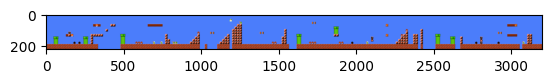

In [ ]:
plt.imshow(Image.open('/home/munasir/image-gpt/igpt-pytorch/pytorch-generative/Mario/n-gram_0.png'))

In [ ]:
class MarioDataset(data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self,train=True, transform=None):
        """
        Args:
            
            root_dir (string): Directory with all the images.
            train:
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.transform = transform
        self.train = train
        
        self.images = []
        if self.train:
            
            for i in range(0,500):
                image = Image.open('/home/munasir/image-gpt/igpt-pytorch/pytorch-generative/Mario/n-gram_'+str(i)+'.png')
                self.images.append(image)
        else:
            
            for i in range(3,5):
                image = Image.open('/home/munasir/image-gpt/igpt-pytorch/pytorch-generative/Mario/n-gram_'+str(i)+'.png')
                self.images.append(image)
        
    

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        if self.train:
            path_1 = '/home/munasir/image-gpt/igpt-pytorch/pytorch-generative/Mario/n-gram_'+str(idx)+'.png'
        else:
            path_1 = '/home/munasir/image-gpt/igpt-pytorch/pytorch-generative/Mario/n-gram_'+str(idx)+'.png'

        
        image = Image.open(path_1)
        image = image.convert('RGB').resize((200,14))
        image = np.array(image)
        image = np.where(image>128,[255],[0])
        #landmarks = self.landmarks_frame.iloc[idx, 1:]
        #landmarks = np.array([landmarks])
        #landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = image

        if self.transform:
            sample = self.transform(sample)

        return sample



In [ ]:



train_set = MarioDataset(train=True, transform=None)
train_eval_set = MarioDataset(train=False, transform=None)

In [ ]:

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image)

In [ ]:



train_set = MarioDataset(train=True, transform=transforms.Compose([ToTensor()]))
train_eval_set = MarioDataset(train=False, transform=transforms.Compose([ToTensor()]))



for i in range(len(train_set)):
    sample = train_set[i]

    print(i, sample.size())

    if i == 3:
        break

0 torch.Size([3, 14, 200])
1 torch.Size([3, 14, 200])
2 torch.Size([3, 14, 200])
3 torch.Size([3, 14, 200])


In [ ]:
def get_mario_loaders(batch_size, dynamically_binarize=False, resize_to_32=False):
    """Create train and test loaders for the MNIST dataset.
    Args:
        batch_size: The batch size to use.
        dynamically_binarize: Whether to dynamically  binarize images values to {0, 1}.
        resize_to_32: Whether to resize the images to 32x32.
    Returns:
        Tuple of (train_loader, test_loader).
    """
    
    train_loader = data.DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        #num_workers=os.cpu_count()-1,
    )
    train_eval_loader = data.DataLoader(
        train_eval_set,
        batch_size=batch_size,
        #num_workers=os.cpu_count()-1,
    )
    return train_loader, train_eval_loader

In [ ]:
import torch
from torch import distributions
from torch import nn

from pytorch_generative import nn as pg_nn
from pytorch_generative.models import base


class TransformerBlock(nn.Module):
    """An ImageGPT Transformer block."""

    def __init__(self, n_channels, n_attention_heads):
        """Initializes a new TransformerBlock instance.

        Args:
            n_channels: The number of input and output channels.
            n_attention_heads: The number of attention heads to use.
        """
        super().__init__()
        self._ln1 = pg_nn.NCHWLayerNorm(n_channels)
        self._ln2 = pg_nn.NCHWLayerNorm(n_channels)
        self._attn = pg_nn.CausalAttention(
            in_channels=n_channels,
            n_heads=n_attention_heads,
            embed_channels=n_channels,
            out_channels=n_channels,
        )
        self._out = nn.Sequential(
            nn.Conv2d(
                in_channels=n_channels, out_channels=4 * n_channels, kernel_size=1
            ),
            nn.GELU(),
            nn.Conv2d(
                in_channels=4 * n_channels, out_channels=n_channels, kernel_size=1
            ),
        )

    def forward(self, x):
        x = x + self._attn(self._ln1(x))
        return x + self._out(self._ln2(x))

class ImageGPT(base.AutoregressiveModel):
    """The ImageGPT Model.

    Unlike [1], our implementation operates over image inputs, instead of
    embeddings. Furthermore, we implement skip connections from each block to the
    output. We find that this makes training a lot more stable and allows for much
    faster convergence.
    """

    def __init__(
        self,
        in_channels=1,
        out_channels=1,
        in_size_0=28,
        in_size_1=28,
        n_transformer_blocks=8,
        n_attention_heads=4,
        n_embedding_channels=16,
        sample_fn=None,
    ):
        """Initializes a new ImageGPT instance.

        Args:
            in_channels: The number of input channels.
            out_channels: The number of output channels.
            in_size: Size of the input images. Used to create positional encodings.
            n_transformer_blocks: Number of TransformerBlocks to use.
            n_attention_heads: Number of attention heads to use.
            n_embedding_channels: Number of attention embedding channels to use.
            sample_fn: See the base class.
        """
        super().__init__(sample_fn)
        self._pos = nn.Parameter(torch.zeros(1, in_channels, in_size_0, in_size_1))
        self._input_1 = pg_nn.CausalConv2d(
            mask_center=True,
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=3,
            padding=1,
        )
        self._input_2 = pg_nn.CausalConv2d(
            mask_center=True,
            in_channels=in_channels,
            out_channels=n_embedding_channels,
            kernel_size=3,
            padding=1,
        )

        self._transformer = nn.ModuleList(
            TransformerBlock(
                n_channels=n_embedding_channels, n_attention_heads=n_attention_heads
            )
            for _ in range(n_transformer_blocks)
        )
        self._ln = pg_nn.NCHWLayerNorm(n_embedding_channels)
        self._out_1 = nn.Conv2d(
            in_channels=n_embedding_channels, out_channels=out_channels, kernel_size=1
        )
        self._out_2 = nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        #x = self._input_1(x + self._pos)
        #x = self._input_1(x + self._pos)
        #x = self._input_1(x + self._pos)
        #x = self._input_1(x + self._pos)
        x = self._input_2(x + self._pos)
        for block in self._transformer:
            x = x + block(x)
        #x = self._out_1(x)
        #x = self._out_1(self._ln(x))
        return self._out_1(self._ln(x))

def reproduce(
    n_epochs=457,
    batch_size=64,
    log_dir="/home/munasir/image-gpt/igpt-pytorch/pytorch-generative",
    n_gpus=1,
    device_id=0,
    debug_loader=None,
):
    """Training script with defaults to reproduce results.
    The code inside this function is self contained and can be used as a top level
    training script, e.g. by copy/pasting it into a Jupyter notebook.
    Args:
        n_epochs: Number of epochs to train for.
        batch_size: Batch size to use for training and evaluation.
        log_dir: Directory where to log trainer state and TensorBoard summaries.
        n_gpus: Number of GPUs to use for training the model. If 0, uses CPU.
        device_id: The device_id of the current GPU when training on multiple GPUs.
        debug_loader: Debug DataLoader which replaces the default training and
            evaluation loaders if not 'None'. Do not use unless you're writing unit
            tests.
    """
    from torch import optim
    from torch.nn import functional as F
    from torch.optim import lr_scheduler

    from pytorch_generative import datasets
    from pytorch_generative import models
    from pytorch_generative import trainer

    train_loader, train_eval_loader = debug_loader, debug_loader
    if train_loader is None:
        train_loader, train_eval_loader = get_mario_loaders(
            batch_size, dynamically_binarize=False
        )

    model = ImageGPT(
        in_channels=3,
        out_channels=3,
        in_size_0=14,
        in_size_1=200,
        n_transformer_blocks=5,
        n_attention_heads=8,
        n_embedding_channels=16,
    )
    optimizer = optim.Adam(model.parameters(), lr=5e-3)#5e-3
    scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda _: 0.999977)

    def loss_fn(x, _, preds):
        x = torch.tensor(x, dtype=torch.float32)
        batch_size = x.shape[0]
        x, preds = x.reshape((batch_size, -1)), preds.reshape((batch_size, -1))
        loss = F.binary_cross_entropy_with_logits(preds, x, reduction="none")
        return loss.sum(dim=1).mean()

    model_trainer = trainer.Trainer(
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        eval_loader=train_eval_loader,
        lr_scheduler=scheduler,
        log_dir=log_dir,
        n_gpus=n_gpus,
        device_id=device_id,
    )
    
    model_trainer.interleaved_train_and_eval(n_epochs)

    return model



In [ ]:
wandb.init(project="Transformer-Mario-PCG",config = {
                    "learning_rate": 5e-3,
                    "epochs": 100,
                    "batch_size": 1,
                    "in_size_0":14,
                    "in_size_1":200,
                    "n_transformer_blocks":5,
                    "n_attention_heads":8,
                    "n_embedding_channels":16,
                    'cnn_layers':1,
                    "Images": 1000
                    })


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: munasir. Use `wandb login --relogin` to force relogin


In [13]:
model = reproduce(n_epochs=422,batch_size=1)

Found 422 saved checkpoints.
Restoring trainer state from checkpoint trainer_state_422.ckpt.


In [14]:
total_params = sum(
	param.numel() for param in model.parameters()
)
print(f"total_params: {total_params}")

trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f"trainable_params: {trainable_params}")


total_params: 25427
trainable_params: 25427


In [15]:
def reshape_output_image(image, imsize=(100, 100)):
  """Reshapes the given image to (imsize, imsize, 3)."""
  width, height = imsize
  return image.reshape(width, height, 3).permute(2,0,1)

_IMAGE_UNLOADER = transforms.Compose(
    [transforms.Lambda(lambda x: x.clone().squeeze(0)), transforms.ToPILImage()]
)

def imshow(batch_or_tensor, title=None, figsize=None, **kwargs):
    """Renders tensors as an image using Matplotlib.

    Args:
        batch_or_tensor: A batch or single tensor to render as images. If the batch size
            > 1, the tensors are flattened into a horizontal strip before being
            rendered.
        title: The title for the rendered image. Passed to Matplotlib.
        figsize: The size (in inches) for the image. Passed to Matplotlib.
        **kwargs: Extra keyword arguments passed as pyplot.imshow(image, **kwargs).
    """
    batch = batch_or_tensor
    for _ in range(4 - batch.ndim):
        batch = batch.unsqueeze(0)
    n, c, h, w = batch.shape
    tensor = batch.permute(1, 2, 0, 3).reshape(c, h, -1)
    image = _IMAGE_UNLOADER(tensor)

    plt.figure(figsize=figsize)
    plt.title(title)
    plt.axis("off")
    plt.imshow(image, **kwargs) 

1693185.8
1624658.4
1668251.0


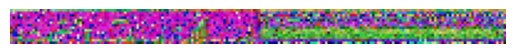

In [46]:




test_image_blank = np.array(Image.new('RGB',(200,14),'yellow')).transpose((2,0,1))
test_image_blank = torch.from_numpy(test_image_blank).to('cuda:0')
#test_image_blank = torch.to(test_image_blank.device)



#image = np.array(Image.open('/home/munasir/image-gpt/igpt-pytorch/pytorch-generative/Mario/n-gram_0.png')).resize((200,14))
#image = image.transpose((2,0,1))
#image = torch.from_numpy(image).to('cuda:0')



im_crop = Image.open('/home/munasir/image-gpt/igpt-pytorch/pytorch-generative/Mario/n-gram_0.png').resize((200,14))
crop_range = (0,0,100,14)
im_crop = im_crop.crop(crop_range)
im2 = Image.new('RGB',(200,14),'white')
im2.paste(im_crop,box=crop_range)
image_crop = np.array(im2)
image_crop = np.expand_dims(image_crop,axis=0)
#image_crop = np.where(image_crop > 128,[256],[0])
image_crop = image_crop.transpose((0,3,1,2))
image_crop = torch.from_numpy(image_crop).to('cuda:0')

def _default_sample_fn(logits):
    return distributions.ContinuousBernoulli(logits=logits).sample()

r = np.random.randint(low = 50,high=1000,size=(1,))
n_samples = 1
with torch.no_grad():
    for _ in range(0,n_samples):
        o = model.forward(image_crop)#next(model.parameters())
        #o = _default_sample_fn(o)
        #o = o / o.max()#Sometimes works sometimes dont
        o = img_as_float(o.cpu().detach().numpy())#(o.cpu().detach().numpy())
        
        #o = o * 255

        print(o.max())
        print(o.min())
        print(o.mean())

    
        imshow(torch.tensor(o[0]))
        '''for rand in r:
            o = model.forward(next(model.parameters())*rand)
            o = o / o.max()#Sometimes works sometimes dont
            o = img_as_float(o.cpu().detach().numpy())#(o.cpu().detach().numpy())


            print(o.max())
            print(o.min())
            print(o.mean())

            o = np.where(o>0.5,[1],[0])
            imshow(torch.tensor(o[0], dtype=torch.float32),cmap='Greys')'''


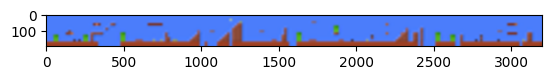

In [ ]:
a = Image.open('/home/munasir/image-gpt/igpt-pytorch/pytorch-generative/Mario/n-gram_0.png').resize((200,14))
a = a.resize((3200,200))
plt.imshow(a)

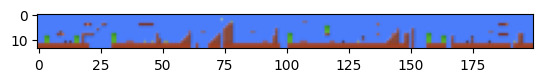

In [ ]:
plt.imshow(Image.open('/home/munasir/image-gpt/igpt-pytorch/pytorch-generative/Mario/n-gram_0.png').resize((200,14)))

In [ ]:
im_crop = Image.open('/home/munasir/image-gpt/Mario/n-gram_0.png').resize((200,14))
crop_range = (0,0,60,14)
im_crop = im_crop.crop(crop_range)
#im_crop.save('/home/munasir/image-gpt/Mario/n-gram_0a.png', quality=95)

FileNotFoundError: [Errno 2] No such file or directory: '/home/munasir/image-gpt/Mario/n-gram_0.png'

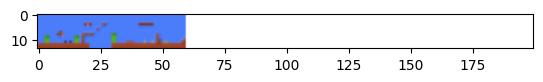

In [ ]:
im2 = Image.new('RGB',(200,14),color='white')
im2.paste(im_crop,box=crop_range)
im2 = np.array(im2)
plt.imshow(im2)

In [ ]:
def loss_fn(x, preds):
    x = torch.tensor(x, dtype=torch.float32)
    batch_size = x.shape[0]
    #x, preds = x.reshape((batch_size, -1)), preds.reshape((batch_size, -1))
    loss = F.binary_cross_entropy_with_logits(preds, x)
    return loss.sum(dim=1).mean()

In [ ]:
x = Image.open('/home/munasir/image-gpt/maze_dataset_test/maze_0_generation.png').convert('RGB')
x = np.array(x)
x = torch.tensor(x)
x = x / x.max()
x = img_as_int(x)

In [ ]:
loss_fn(x,o[0])

TypeError: 'int' object is not callable

In [ ]:
o.shape

(1, 3, 32, 32)

In [ ]:
model = torch.load('/home/munasir/image-gpt/igpt-pytorch/pytorch-generative/trainer_state_600.ckpt')

In [ ]:
model['model']['_input.weight'].shape

torch.Size([256, 3, 3, 3])

In [ ]:
len(model)

7